In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
!{sys.executable} -m pip install --upgrade "statsmodels==0.11"

  Using cached https://files.pythonhosted.org/packages/4d/a6/685d3ed1e1de53d2c19f8dd76ac03cbd144302a9ab59a743308d69aba3c9/statsmodels-0.11.0-cp37-cp37m-manylinux1_x86_64.whl
  Found existing installation: statsmodels 0.12.1
    Uninstalling statsmodels-0.12.1:
      Successfully uninstalled statsmodels-0.12.1


In [2]:
plt.rcParams["figure.figsize"] = [10, 5]

# Load data
Load the birth_data.csv file used in lab 1.

In [3]:
data = pd.read_csv('../resources/birth_data.csv', parse_dates=['Date'])

print(data.dtypes)
display(data)

Date      datetime64[ns]
Births             int64
dtype: object


,Date,Births
0,2010-01-01,6
1,2010-01-02,7
2,2010-01-03,6
3,2010-01-04,5
4,2010-01-05,8
...,...,...
1821,2014-12-27,14
1822,2014-12-28,37
1823,2014-12-29,32
1824,2014-12-30,40


## Group data by year and month
Group the data by year and month, and sum the births for each month.  Set the index to the month, and the frequency to monthly.

[See the documentation for asfreq](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.asfreq.html)

In [4]:
# your code here

data['month'] = data['Date'].apply(lambda d: datetime(d.year, d.month, 1))

monthly_data = pd.DataFrame(data.groupby(by='month')['Births'].sum()).asfreq('MS')

display(monthly_data.head())

,Births
month,
2010-01-01,221
2010-02-01,201
2010-03-01,223
2010-04-01,214
2010-05-01,220


## Plot the data
Plot the timeseries data in a line plot.  Plot a boxplot for data grouped by month of the year and by year.

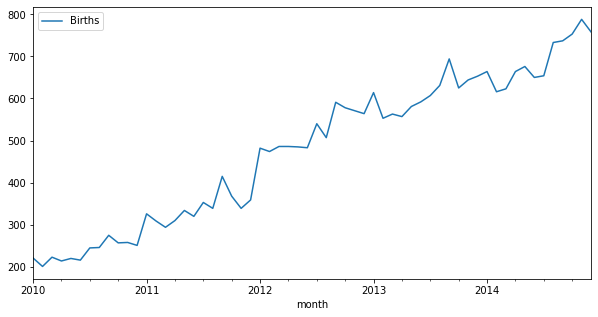

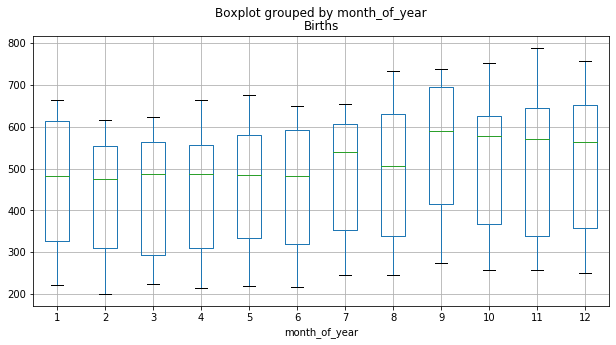

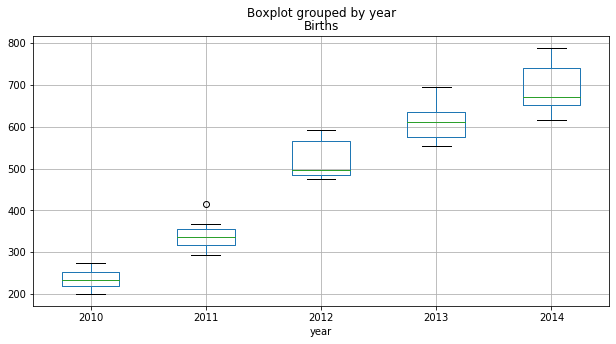

In [5]:
# your code here

ax = monthly_data.plot(y='Births')

plt.show()

monthly_data['year'] = [d.year for d in monthly_data.reset_index()['month']]
monthly_data['month_of_year'] = [int(d.strftime('%m')) for d in monthly_data.reset_index()['month']]

monthly_data.boxplot('Births', 'month_of_year')
monthly_data.boxplot('Births', 'year')

## Decompose the data into trend, seasonal, and error
Plot the decomposition.

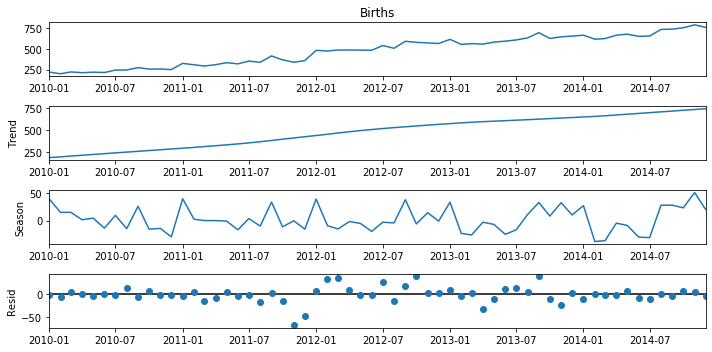

In [6]:
# your code here

from statsmodels.tsa.seasonal import STL
decomp_result = STL(monthly_data['Births'], robust=True).fit()
decomp_result.plot()
plt.show()

## Test for stationarity
Use the Augmented Dickey-Fuller test

In [7]:
# your code here

from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_data['Births'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -0.5563842866720247
p-value: 0.8805360235485389


## If necessary, transform the timeseries to be stationary
Based on the p value you received, and comparing to $\alpha$ = 0.05, it may or may not be necessary to take one or more diffs on the data.

,Births,year,month_of_year
month,,,
2010-01-01,NaN,NaN,NaN
2010-02-01,-20.0,0.0,1.0
2010-03-01,22.0,0.0,1.0
2010-04-01,-9.0,0.0,1.0
2010-05-01,6.0,0.0,1.0


ADF Statistic: -1.8337419032578155
p-value: 0.3638430665420822


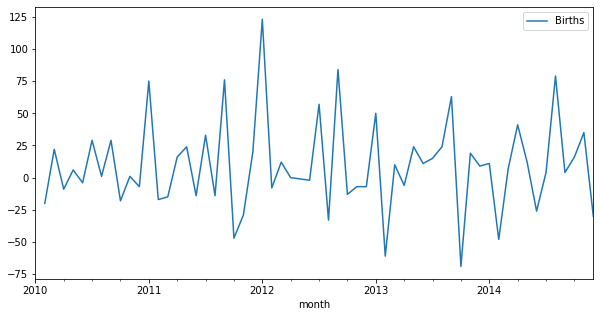

In [8]:
# your code here

# Because the p value is above 0.05, we do not reject the null that the timeseries is not stationary

# take a first order diff and test again
diff_data = monthly_data.diff()
display(diff_data.head())

diff_data.reset_index().plot('month', 'Births')

result = adfuller(diff_data['Births'].dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

,Births,year,month_of_year
month,,,
2010-01-01,NaN,NaN,NaN
2010-02-01,NaN,NaN,NaN
2010-03-01,42.0,0.0,0.0
2010-04-01,-31.0,0.0,0.0
2010-05-01,15.0,0.0,0.0


ADF Statistic: -4.668351059999668
p-value: 9.645980844469244e-05


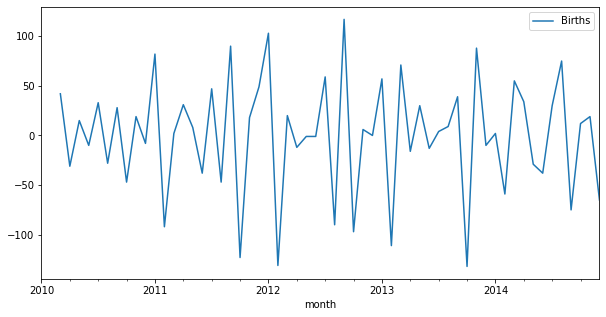

In [9]:
# take a second order diff and test again
diff_data = monthly_data.diff().diff()
display(diff_data.head())

diff_data.reset_index().plot('month', 'Births')

result = adfuller(diff_data['Births'].dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

## Plot the monthly data, the decomposed trend, and the de-trended data

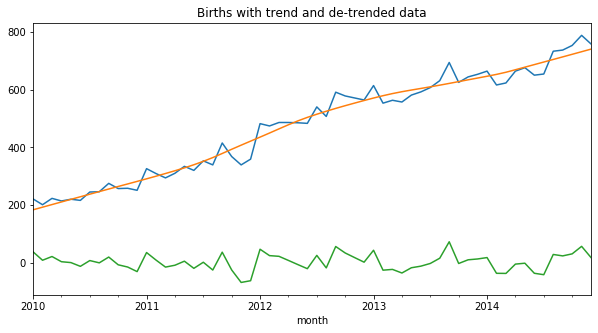

In [10]:
# your code here

monthly_data['Births'].plot()

decomp_result.trend.plot()

(monthly_data['Births'] - decomp_result.trend).plot()
_ = plt.title('Births with trend and de-trended data')

## Make lag plots and check for autocorrelation
Is there evidence that the data is autocorrelated?

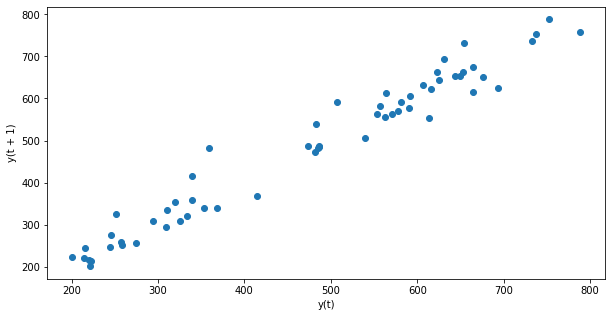

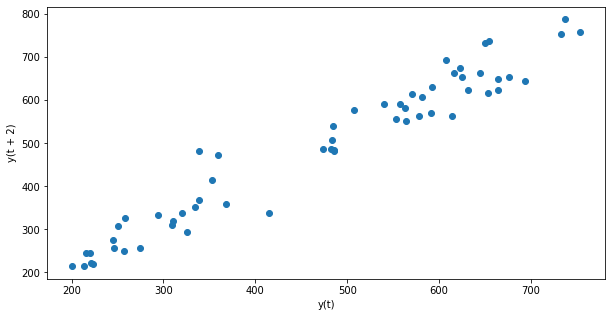

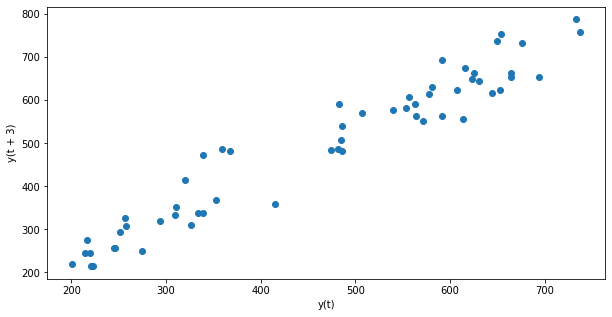

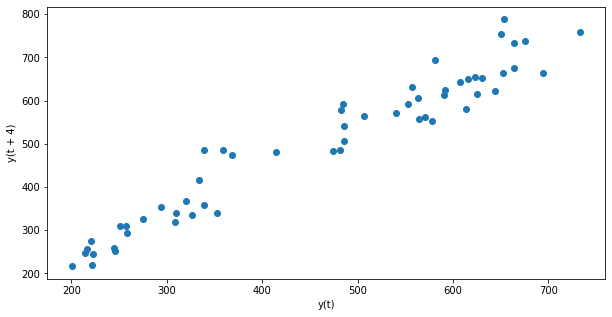

There is evidence that the data are autocorrelated, because the plots retain a fairly strong linear component through the fourth order lag 


In [11]:
# your code here

from pandas.plotting import lag_plot

for i in range(1,5):
    lag_plot(monthly_data['Births'], lag=i)
    plt.show()

print('There is evidence that the data are autocorrelated, because the plots retain a fairly strong linear component through the fourth order lag ')

## Make an autocorrelation plot using the order of diff required to make the time series stationary
Show 50 lags in the plot.

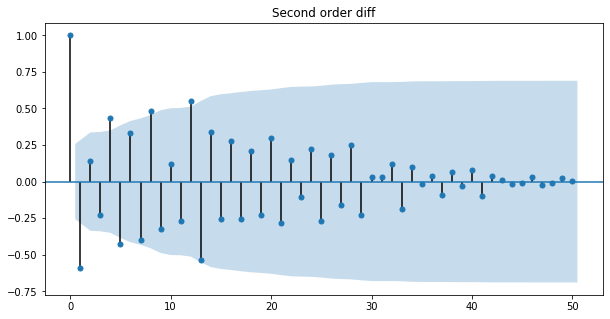

In [12]:
# your code here

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(monthly_data['Births'].diff().diff().dropna(), title='Second order diff', lags=50)
plt.show()



## Estimate the AR term required for an ARIMA
Use the partial autocorrelation plot.

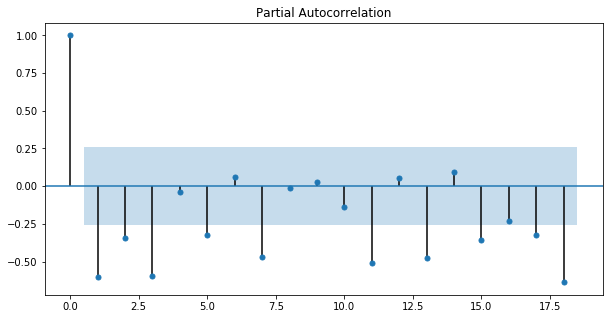

The estimated AR term is 4.  It is the first lag to fall within the confidence interval.   This will be the p value for the ARIMA


In [13]:
# your code here

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(monthly_data['Births'].diff().diff().dropna())
plt.show()

print('The estimated AR term is 4.  It is the first lag to fall within the confidence interval.   This will be the p value for the ARIMA')

## Estimate the MA term required for ARIMA
Use the autocorrelation plot.

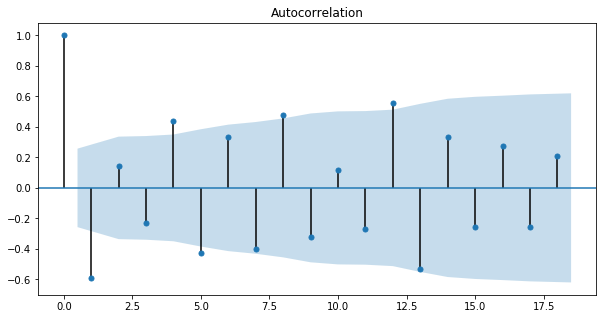

The estimated MA term is 2.  It is the first lag to fall within the confidence interval.  This will be the q value for the ARIMA


In [14]:
# your code here

plot_acf(monthly_data['Births'].diff().diff().dropna())
plt.show()

print('The estimated MA term is 2.  It is the first lag to fall within the confidence interval.  This will be the q value for the ARIMA')

## Fit an ARIMA model using the parameters you have found

In [15]:
# your code here

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(monthly_data['Births'], order=(4,2,2))
fit = model.fit()
print(fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D2.Births   No. Observations:                   58
Model:                 ARIMA(4, 2, 2)   Log Likelihood                -279.773
Method:                       css-mle   S.D. of innovations             28.489
Date:                Tue, 01 Feb 2022   AIC                            575.546
Time:                        08:39:28   BIC                            592.030
Sample:                    03-01-2010   HQIC                           581.967
                         - 12-01-2014                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0313      0.135      0.232      0.816      -0.233       0.295
ar.L1.D2.Births    -1.1355      0.166     -6.839      0.000      -1.461      -0.810
ar.L2.D2.Births    -0.5836      

## Refine the model
Based on the p values of the auto regressive and moving average parameters, run a new model and compare.

In [16]:
# your code here

# Based on the p values, the AR parameter could be scaled back to 2, and the MA paramter to zero

model2 = ARIMA(monthly_data['Births'], order=(2,2,0))
fit2 = model2.fit()
print(fit2.summary())

                             ARIMA Model Results                              
Dep. Variable:              D2.Births   No. Observations:                   58
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -301.405
Method:                       css-mle   S.D. of innovations             43.454
Date:                Tue, 01 Feb 2022   AIC                            610.811
Time:                        08:39:28   BIC                            619.052
Sample:                    03-01-2010   HQIC                           614.021
                         - 12-01-2014                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0736      2.692      0.027      0.978      -5.203       5.350
ar.L1.D2.Births    -0.8076      0.124     -6.526      0.000      -1.050      -0.565
ar.L2.D2.Births    -0.3377      

## Interpret the results
Based on the two models' AIC, which one appears to be better?

your interpretation here

We would use the first model, as it's AIC is lower.

## Create a train/test split and evaluate the performance of the first model
1. Plot the predicted versus actual values from the test set
1. Evaluate the model using MAPE and correlation between the predicted and actual values.

training data min, max: 2010-01-01 00:00:00 2013-04-01 00:00:00
testing data min, max:  2013-05-01 00:00:00 2014-12-01 00:00:00


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


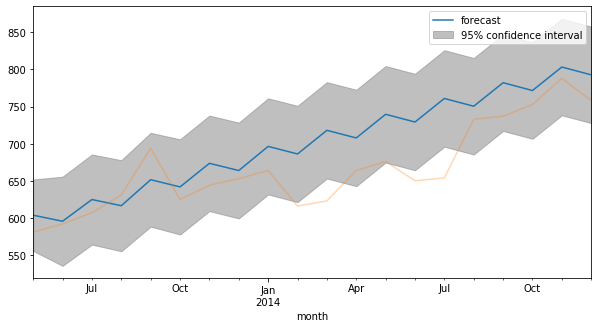

,0,1
0,581.0,603.712672
1,592.0,595.561961
2,607.0,624.816516
3,631.0,616.506408
4,694.0,651.520999
5,625.0,641.830068
6,644.0,673.584892
7,653.0,663.872944
8,664.0,696.387147
9,616.0,686.177438


MAPE:    0.059194296944068636
Corr:    0.8360626980120142


In [17]:
# your code here

import math

def mape(predicted, data):
    return np.mean(np.abs(predicted - data)/np.abs(data))

def corr(predicted, data):
    return np.corrcoef(predicted, data)[0,1] 

cut_point = math.trunc(len(monthly_data)*0.67)
train = monthly_data[:cut_point]
test = monthly_data[cut_point:]

print('training data min, max:', train.index.min(), train.index.max())
print('testing data min, max: ', test.index.min(), test.index.max())

model = ARIMA(train['Births'], order=(4, 1, 2))  
fit = model.fit(disp=-1)  

fig = fit.plot_predict(test.index.min(), test.index.max(), plot_insample=False)
monthly_data.loc[test.index.min():]['Births'].plot(fig=fig, alpha=0.3)
plt.show()

## metrics
num_observations = len(test)
predicted, se, conf = fit.forecast(num_observations, alpha=0.05)

display(pd.DataFrame(np.vstack([test[:num_observations]['Births'], predicted])).T)

print('MAPE:   ', mape(predicted, test[:num_observations]['Births']))
print('Corr:   ', corr(predicted, test[:num_observations]['Births']))

## Create a train/test split and evaluate the performance of the second model
1. Plot the predicted versus actual values from the test set
1. Evaluate the model using MAPE and correlation between the predicted and actual values.

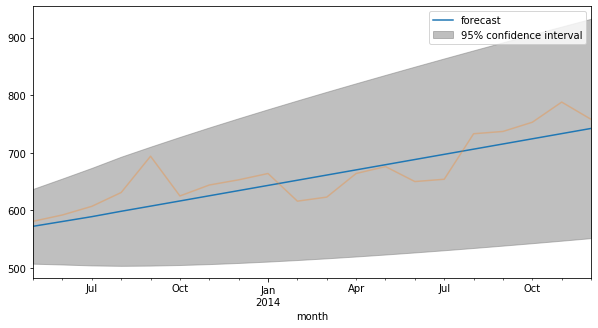

,0,1
0,581.0,572.331174
1,592.0,580.671845
2,607.0,589.066197
3,631.0,598.409472
4,694.0,607.335328
5,625.0,616.309558
6,644.0,625.320937
7,653.0,634.309539
8,664.0,643.302816
9,616.0,652.297240


MAPE:    0.03985162173499371
Corr:    0.8401621399123329


In [18]:
# your code here

model = ARIMA(train['Births'], order=(2, 1, 0))  
fit = model.fit(disp=-1)  

fig = fit.plot_predict(test.index.min(), test.index.max(), plot_insample=False)
monthly_data.loc[test.index.min():]['Births'].plot(fig=fig, alpha=0.3)
plt.show()

## metrics
num_observations = len(test)
predicted, se, conf = fit.forecast(num_observations, alpha=0.05)

display(pd.DataFrame(np.vstack([test[:num_observations]['Births'], predicted])).T)

print('MAPE:   ', mape(predicted, test[:num_observations]['Births']))
print('Corr:   ', corr(predicted, test[:num_observations]['Births']))

## Based on the MAPE and Corr between the two models, which model performed better?


your interpretation here

The second model performed better.  The MAPE was lower, meaning more of the variance was handled by the model, and the correlation was higher.